# Accessing Maze Data
@peterdoohan

If have not cloned the main code repo for an experiment and you want to access the project code so you can access the data you will need to add the project code folder to youre python directory. Alternatively you can clone the project repo from from GitHub and organise the code however you see fit.

In [1]:
import sys

PROJECT_CODE_PATH = "/ceph/behrens/peter_doohan/goalNav_mFC/experiment/code"
sys.path.append(PROJECT_CODE_PATH)

We can now access the ```GridMaze.core``` module which gives us some easy ways to access data for analyses

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from GridMaze.maze import representations as mr
from GridMaze.maze import plotting as mp
from GridMaze.analysis.core import get_sessions as gs
from GridMaze.analysis.core import get_clusters as gc

## Processed Data

Let's load a Session object  with all the processed data to remind yourselves about data associated with a single maze session

In [3]:
session = gs.get_maze_sessions(
    subject_IDs=["m2"],
    maze_names=["maze_1"],
    days_on_maze=[10],
    with_data=[
        "events_df",  # events.htsv on disk
        "trials_df",  # trials.htsv on disk
        "spike_times",  # spikes.times.npy on disk
        "spike_clusters",  # spikes.clusters.npy on disk
        "cluster_metrics",  # clusters.metrics.hstv on disk
        "tracking_df",  # frames.tracking.hstv on disk
        "trajectories_df",  # frames.trajectories.hstv on disk
        "trial_info_df",  # trialsInfo.hstv on disk
        "lfp_times",  # lfp.times.npy on disk
        "lfp_signal",  # lfp.signal.npy on disk
        "lfp_metrics",  # lfp.metrics.hstv on disk
    ],
)

print(session)


-MazeSession--------------------------------------------------
  Subject ID     : m2                      
  Maze Name      : maze_1                  
  Day on Maze    : 10                      
  Goal Subset    : all                     
  Date           : 2022-07-02              
---------------------------------------------------------------



Here we loaded the session object with all the processed data associated with this experiment, we have data related to ephys (spikes & lfp), data associated with video tracking and data associated with trial events. Let's go through these data structures one by one to see how they are structured.

Note: 
- that all times referenced in these data structures are the common pycontrol time
- all units are SI convention unless stated otherwise

1. "trials_df"
- This data structure contains behavioural information relevatnt to evert trial in the session organised in a pandas DataFrame. Note that in this example experiment, each trial consists of a goal location being cued, then the animals navigating to the goal, getting a water reward, then an intertrial interval (ITI) before the next goal is cued. 
- Each row of the dataframe represents a trial and contains information about the:
    - trial number
    - goal that was active
    - number of error pokes (pokes into locations that were not the goal)
    - times of various trial events
        - cue: when the goal was cued
        - reward: when the animal first poked into the reward port
        - end_reward_consumption: when the animal left the reward port
        - ITI_start: start of ITI according to pycontrol
        - trial_end: end of ITI and start of new trial

In [4]:
trials_df = session.trials_df
trials_df.head(10)

trial goal errors     time                                            \
                         cue   reward end_reward_consumption ITI_start   
0     1   D3      9    7.007  116.027                120.140   120.649   
1     2   F7      2  124.650  153.033                154.613   155.122   
2     3   C7      0  161.123  170.887                176.207   176.716   
3     4   D6      3  182.717  273.489                274.447   274.957   
4     5   G1      5  279.958  333.167                337.863   338.373   
5     6   B4      3  345.374  393.558                394.384   394.893   
6     7   E3      0  402.894  416.290                417.171   417.681   
7     8   C5      0  421.682  424.089                424.707   425.217   
8     9   F2      0  431.218  440.683                441.396   441.905   
9    10   E6      0  446.906  465.110                465.816   466.326   

             
  trial_end  
0   124.650  
1   161.123  
2   182.717  
3   279.958  
4   345.374  
5   402.894  
6   421.682  
7   431.218  
8   446.906  
9   471.327

2. "events_df"
    - This is a pandas DataFrame that details all of the events registered by pycontrol on the maze. Eg, when trial events happened (eg, cue, reward, etc.) and any hardware events happened (eg, "E6_in": subject poked into "E6" port)
    - This data structure is useful for more detailed analyses of behaviour that might focus on error pokes (pokes that were not in the reward port), those times are easy to review from this data structure. 

In [5]:
events_df = session.events_df
events_df.head(10)

,type,name,time,duration,value
0,state,ITI,0.000,7.007,NaN
1,state,cue,7.007,109.020,NaN
2,print,NaN,7.013,NaN,Start trial - T#:1 S#:D3 sT#:7007
3,event,E6_in,14.032,0.748,NaN
4,event,D7_in,20.051,0.244,NaN
5,event,C6_in,26.824,0.476,NaN
6,event,F1_in,42.742,0.057,NaN
7,event,G7_in,85.980,1.809,NaN
8,event,G6_in,94.894,0.088,NaN
9,event,G6_out,95.111,NaN,NaN


3. "spike_times"
4. "spike_clusters"
- Times of every spike that occured during the session and the cluster_ID associated with it
- loaded as np.arrays

In [6]:
spike_times = session.spike_times
spike_clusters = session.spike_clusters
print(spike_times)
print(spike_clusters)

[ -47.06556324  -47.0647299   -47.0626632  ... 2415.62341898 2415.62378565
 2415.62435232]
[136  38  42 ...  34  15  16]


5. "cluster_metrics"
-  a pandas DataFrame with rows for each cluster (ephys name for neuron or putative neuron) recorded in the session, detailing:
    - quality metrics:
        - firing_rate (average firing rate)
        - presence ratio 
        - isi_violations_ratio
        - amplitude_median
        - ampliude_cutoff
        - sd_ratio
        see SpikeInterface [documentation]("https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html) for what these say about a cluster if you are interested
    - boolians for classication as single_unit, mulit_unit & noise_unit
    - contact information (i.e the primary channel on the probe the unit was recorded on)
        - id
        - shank (these recordings were made on 6-shank probes)
        - x,y position of the shank relative to the probe (um)
    - probe_depth (depth in the brain, relative to surface, the cluster was recorded at)
    - tissue_sample (the probes were moved on a microdrive for this experiment a few times, tissue samples id a period of time we recorded from a bit of tissue before lowering the probe).
    - voxel (voxel in AllenCCFv3 coordinates 25um atlas the unit was recorded in)
    - region (AllenCCFv3 region name and abbreviation of the cluster)

In [7]:
cluster_metrics = session.cluster_metrics
cluster_metrics.head(5)

cluster_ID quality_metrics                                      \
                 firing_rate presence_ratio isi_violations_ratio   
0          0        2.485524            1.0             1.489867   
1          1        2.565518            1.0             1.172192   
2          2        9.598969            1.0             0.095486   
3          3        8.885513            1.0             0.066861   
4          4        1.866681            1.0             0.038845   

                                              single_unit multi_unit  \
  amplitude_cutoff amplitude_median  sd_ratio                          
0         0.000826        78.780000  4.686416       False       True   
1         0.008078        19.695000  1.516020       False      False   
2         0.000037        76.049995  1.322952        True      False   
3         0.000196        74.100000  1.443254        True      False   
4         0.001197       169.650000  1.459052        True      False   

  noise_unit  ... tissue_sample probe_depth contact              voxel       \
              ...                             shank      x     y     x    y   
0      False  ...             B        1300       2  400.0  30.0   133  108   
1       True  ...             B        1300       2  400.0  30.0   133  108   
2      False  ...             B        1300       2  400.0  30.0   133  108   
3      False  ...             B        1300       2  400.0  30.0   133  108   
4      False  ...             B        1300       2  416.5  75.0   132  107   

        region                           
     z acronym                     name  
0  252     PL5  Prelimbic area, layer 5  
1  252     PL5  Prelimbic area, layer 5  
2  252     PL5  Prelimbic area, layer 5  
3  252     PL5  Prelimbic area, layer 5  
4  252     PL5  Prelimbic area, layer 5  

[5 rows x 21 columns]

6. "tracking_df"
    - This contains the position (x,y in meters) of all the bodyparts tracked by SLEAP/Deeplab cut
    - rows represent frames of video
    - These have not been quality controlled for tracking errors and contain NaNs where the body part position could not be estimated.
    - This data structure could be used for MoSeq or more complicated analyses of subject pose etc. 
    - loaded as pandas DataFrame

In [8]:
tracking_df = session.tracking_df
tracking_df.head(10)

head_front      head_mid           head_back               ear_L            \
           x   y         x         y         x         y         x         y   
0        NaN NaN  0.489365  0.502220  0.483139  0.505903  0.482787  0.508674   
1        NaN NaN  0.491436  0.499798  0.484940  0.502908  0.486652  0.506823   
2        NaN NaN  0.487993  0.497162  0.483041  0.501074  0.483549  0.503891   
3        NaN NaN  0.488832  0.495763  0.483072  0.499959  0.484442  0.502911   
4        NaN NaN  0.490155  0.496078  0.484136  0.500687  0.485352  0.503586   
5        NaN NaN  0.495935  0.489752  0.491310  0.496559  0.488812  0.495714   
6        NaN NaN  0.495229  0.490661  0.489878  0.497459  0.488994  0.496703   
7        NaN NaN  0.494711  0.487634  0.491615  0.493191  0.489963  0.493363   
8        NaN NaN  0.499232  0.486090  0.497142  0.492370  0.495119  0.491386   
9        NaN NaN  0.499035  0.488745  0.496890  0.495794  0.494942  0.493032   

      ear_R           body_front            body_mid           body_back  \
          x         y          x         y         x         y         x   
0  0.480684  0.500693   0.474669  0.510059  0.454935  0.514180  0.438195   
1  0.482538  0.498521   0.475340  0.505933  0.457557  0.511149  0.440269   
2  0.480413  0.496868   0.472075  0.503700  0.456401  0.510648  0.439202   
3  0.480312  0.495993   0.473784  0.503608  0.457216  0.509670  0.439486   
4  0.481442  0.496676   0.474572  0.504812  0.457158  0.511391  0.439269   
5  0.487809  0.492635   0.480108  0.500316  0.461428  0.509299  0.443185   
6  0.485957  0.493625   0.479184  0.501792  0.459234  0.510082  0.440935   
7  0.488305  0.489971   0.480264  0.499364  0.461406  0.507740  0.442921   
8  0.492660  0.490524   0.484909  0.498397  0.465029  0.507278  0.445010   
9  0.493282  0.492243   0.486033  0.500818  0.466122  0.509227  0.446735   

             
          y  
0  0.519283  
1  0.516859  
2  0.516078  
3  0.515608  
4  0.517789  
5  0.515093  
6  0.517575  
7  0.514028  
8  0.514077  
9  0.516130

7. "trajectories_df"
- conatins quality controlled frame by frame tracking information during the session, including:
    - "head_direction": in degrees, with note on if the value was interpolated from surrounding values during quality control
    - "centroid_position": in meters, with similar notes on interpolation. Taken as the position of the back of the animals head throughout the session
    - "maze_position":
        - "simple": node or egde on the simple maze (quality controlled so invalid transitions on the maze are corrected)
        - "skeleton": node or egde on the skeleton maze (not quality controlled as above)
    - "time": time in session
- loaded as pandas DataFrame


In [9]:
trajectories_df = session.trajectories_df
trajectories_df.head(10)

time head_direction              centroid_position            \
                     value interpolated                 x         y   
0 -6.767164     337.312370            0          0.483139  0.505903   
1 -6.750496     334.027132            0          0.484940  0.502908   
2 -6.733828     328.812234            0          0.483041  0.501074   
3 -6.717161     326.543193            0          0.483072  0.499959   
4 -6.700493     326.525941            0          0.484136  0.500687   
5 -6.683825     323.080193            0          0.491310  0.496559   
6 -6.667157     311.794868            0          0.489878  0.497459   
7 -6.650489     316.541399            0          0.491615  0.493191   
8 -6.633821     288.862301            0          0.497142  0.492370   
9 -6.617153     291.171536            0          0.496890  0.495794   

               maze_position           
  interpolated        simple skeleton  
0            0            C3     C3_C  
1            0            C3     C3_C  
2            0            C3     C3_C  
3            0            C3     C3_C  
4            0            C3     C3_C  
5            0            C3     C3_C  
6            0            C3     C3_C  
7            0            C3     C3_C  
8            0            C3     C3_C  
9            0            C3     C3_C

8. trial_info_df
- contains information about what trial was active, what navigational phase ("navigation", "reward_consumption", "ITI") the subject was in and what goal was active for every frame of video
- loaded as pandas DataFrame

In [10]:
trial_info_df = session.trial_info_df
trial_info_df.iloc[1000:1010]

,trial,trial_phase,goal
1000,1.0,navigation,D3
1001,1.0,navigation,D3
1002,1.0,navigation,D3
1003,1.0,navigation,D3
1004,1.0,navigation,D3
1005,1.0,navigation,D3
1006,1.0,navigation,D3
1007,1.0,navigation,D3
1008,1.0,navigation,D3
1009,1.0,navigation,D3


Note:
- tracking_df, trajectories_df and trial_info df all have the same columns so can easily be used to index eachother

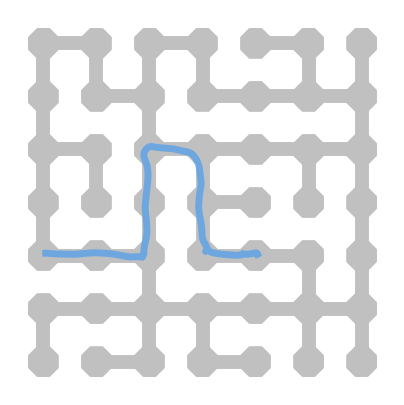

In [11]:
# filter the navigation component of trial 42
trial_42_navigation = trajectories_df[(trial_info_df.trial == 42) & (trial_info_df.trial_phase == "navigation")]
x, y = trial_42_navigation.centroid_position.x, trial_42_navigation.centroid_position.y

# get the session's maze with this class method
simple_maze = session.simple_maze()

# add some smoothing and plot
x = gaussian_filter1d(x, sigma=5)
y = gaussian_filter1d(y, sigma=5)
f, ax = plt.subplots(1, 1, figsize=(5, 5))
mp.plot_simple_maze_silhouette(simple_maze, color="silver", ax=ax)
ax.plot(x, y, color="dodgerblue", lw=5, alpha=0.5)

9. "lfp_times"
- times assoicated with every axis=1 value of lfp_signal (seconds relative to pycontrol same as everything else)
- loaded as np.array

In [12]:
lfp_times = session.lfp_times
print(lfp_times)

[ -47.06579658  -47.0651299   -47.06446323 ... 2415.62431899 2415.62498566
 2415.62565234]


10. "lfp_signal"
- LFP singal (in uV) loaded as np.array.
- Contains LFP signal from a subset of channels on the probe

In [13]:
lfp_signal = session.lfp_signal
print(lfp_signal.shape)  # (n_channels, n_samples)
print(lfp_signal)

(3693990, 34)
[[  -9.359375   -11.3125     -37.0625    ...  -25.734375   -38.8125
     0.       ]
 [ -17.15625    -16.375      -60.0625    ...  -34.71875    -21.453125
    17.546875 ]
 [ -30.421875   -35.09375    -76.8125    ...  -60.4375     -25.546875
     7.9960938]
 ...
 [ -20.46875    -15.015625  -110.        ...  -38.21875    -17.9375
   -94.9375   ]
 [ -10.140625     2.5351562  -75.875     ...  -22.03125      4.6796875
  -103.375    ]
 [  -8.1875      11.1171875  -45.8125    ...   -7.0195312   17.75
   -60.65625  ]]


11. "lfp_metrics"
- loads a pandas Dataframe with same axis=0 as lfp_signal, with information about the probe contacts associated with the lfp_signal, containing information on:
    - tissue_sample
    - probe_depth
    - conrtact: id & shank
    - voxel
    - region
    - quality control (qc), if the channel was "good" "bad" or "dead"
    - sampling rate of the channel (Hz)
- this can be used for indexing lfp signal, eg. if you want to get the lfp associated with a particular shank or depth on the probe. 

In [14]:
lfp_metrics = session.lfp_metrics
lfp_metrics.head(10)

tissue_sample probe_depth contact                      voxel            \
                                 id shank       x      y     x    y    z   
0             B        1300       5     5  1000.0   60.0   155  107  253   
1             B        1300       6     4   800.0  150.0   148  104  253   
2             B        1300       7     3   600.0   30.0   141  108  252   
3             B        1300       9     2   400.0   30.0   133  108  252   
4             B        1300      13     0     0.0    0.0   163  110  253   
5             B        1300      14     1   200.0   90.0   126  106  251   
6             B        1300      15     1   200.0   30.0   126  108  251   
7             B        1300      16     0     0.0   90.0   163  106  253   
8             B        1300      17     5  1000.0  120.0   155  105  253   
9             B        1300      18     3   600.0   90.0   141  106  252   

   region                                                 contact  \
  acronym                                            name      qc   
0     PL5                         Prelimbic area, layer 5    good   
1     PL5                         Prelimbic area, layer 5    good   
2     PL5                         Prelimbic area, layer 5    good   
3     PL5                         Prelimbic area, layer 5    good   
4   ACAv5  Anterior cingulate area, ventral part, layer 5    good   
5     PL5                         Prelimbic area, layer 5    good   
6     PL5                         Prelimbic area, layer 5    dead   
7   ACAv5  Anterior cingulate area, ventral part, layer 5    good   
8     PL5                         Prelimbic area, layer 5    good   
9     PL5                         Prelimbic area, layer 5    good   

  sampling_rate  
                 
0          1500  
1          1500  
2          1500  
3          1500  
4          1500  
5          1500  
6          1500  
7          1500  
8          1500  
9          1500

12. "session_info"
- a dicitionary with static information about the session:
    - subject_ID
    - session_type
    - session_date
    - experimental_day
    - maze_name
    - maze_structure
    - reward size
    - probe_depth
    - tissue_sample 


In [15]:
session_info = session.session_info
print(session_info)

{'subject_ID': 'm2', 'session_type': 'maze', 'session_date': '2022-07-02', 'experimental_day': 10, 'maze_name': 'maze_1', 'maze_structure': ['A1-A2', 'A3-A4', 'A4-A5', 'A5-A6', 'A6-A7', 'A2-B2', 'A3-B3', 'A5-B5', 'A7-B7', 'B4-B5', 'B6-B7', 'B1-C1', 'B2-C2', 'B3-C3', 'B6-C6', 'C1-C2', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C2-D2', 'C5-D5', 'C7-D7', 'D1-D2', 'D3-D4', 'D4-D5', 'D6-D7', 'D1-E1', 'D2-E2', 'D3-E3', 'D4-E4', 'D5-E5', 'D6-E6', 'E2-F2', 'E3-F3', 'E5-F5', 'E6-F6', 'E7-F7', 'F1-F2', 'F2-F3', 'F4-F5', 'F6-F7', 'F2-G2', 'F5-G5', 'F6-G6', 'G1-G2', 'G2-G3', 'G3-G4', 'G4-G5', 'G5-G6', 'G6-G7'], 'day_on_maze': 10, 'goal_subset': 'all', 'goals': ['A2', 'A3', 'A6', 'B4', 'B5', 'B6', 'C1', 'C3', 'C5', 'C7', 'D2', 'D3', 'D6', 'E1', 'E3', 'E4', 'E5', 'E6', 'F2', 'F4', 'F7', 'G1', 'G4', 'G7'], 'reward_size': '8uL', 'probe_depth': 1300.0, 'tissue_sample': 'B'}


## Analysis Data (optional)

Prorcessed data is nice because it dosn't take up too much room on disk (minimally redudant) and it is human readable. However, when it comes to analysis some times you end up making the same computions over and over for different analyses (eg, translating from spike times to firing rates across frames of video), it can be nice to save out derivative "analysis" data structures who's main purpose is being useful for analysis. 

Analysis data for GridMaze projects is ment to be analysis specific, where each person making new analyses is free to add whatever is convenient for them to their analysis data folder (Note this is different than processed data, which is generated once and should be used as the base data for everyone doing analysis on a project). This tutorial dosn't go into detail about how to make your own analysis data but it is possible (message me and we can figue it out). 

Below, I'll illustrate a few analysis data structures that have been useful for my analyses, they can be loaded same as processed data structures with get_maze_sessions(). 

In [18]:
session = gs.get_maze_sessions(
    subject_IDs=["m2"],
    maze_names=["maze_1"],
    days_on_maze=[10],
    with_data=[
        "cluster_metrics",
        "navigation_df",
        "navigation_spike_rates_df",
        "navigation_spike_counts_df",
    ],
)

1. "navigation_df"
- this loads a pandas DataFrame that combines information from many processed data structures into one place, see the df.columns to get a feel for what is in there. 

In [19]:
navigation_df = session.navigation_df
print(navigation_df.columns)

MultiIndex([(                       'time',              ''),
            (                 'subject_ID',              ''),
            (                  'maze_name',              ''),
            (                'day_on_maze',              ''),
            (            'trial_unique_ID',              ''),
            (                      'trial',              ''),
            (                'trial_phase',              ''),
            (                       'goal',              ''),
            (             'head_direction',         'value'),
            (          'centroid_position',             'x'),
            (          'centroid_position',             'y'),
            (              'maze_position',        'simple'),
            (              'maze_position',      'skeleton'),
            (                   'velocity',             'x'),
            (                   'velocity',             'y'),
            (                      'speed',              ''),
        

2. navigation_spike_counts_df
3. navigation_spike_rates_df
- these DataFrames contain the spike counts or firing rate for each cluster on each frame of video recorded in the session

In [20]:
navigation_spike_counts_df = session.navigation_spike_counts_df
navigation_spike_counts_df.head(10)

spike_count                              \
          m2.2022-07-02.maze_cluster0 m2.2022-07-02.maze_cluster1   
time                                                                
-6.767164                           0                           0   
-6.750496                           0                           0   
-6.733828                           0                           0   
-6.717161                           0                           0   
-6.700493                           0                           0   
-6.683825                           0                           0   
-6.667157                           0                           0   
-6.650489                           0                           0   
-6.633821                           0                           0   
-6.617153                           0                           0   

                                                                   \
          m2.2022-07-02.maze_cluster2 m2.2022-07-02.maze_cluster3   
time                                                                
-6.767164                           0                           0   
-6.750496                           0                           0   
-6.733828                           0                           0   
-6.717161                           0                           0   
-6.700493                           0                           0   
-6.683825                           0                           0   
-6.667157                           0                           0   
-6.650489                           0                           0   
-6.633821                           0                           0   
-6.617153                           0                           0   

                                                                   \
          m2.2022-07-02.maze_cluster4 m2.2022-07-02.maze_cluster5   
time                                                                
-6.767164                           0                           0   
-6.750496                           0                           0   
-6.733828                           0                           1   
-6.717161                           0                           0   
-6.700493                           0                           1   
-6.683825                           0                           1   
-6.667157                           0                           0   
-6.650489                           0                           0   
-6.633821                           0                           0   
-6.617153                           0                           0   

                                                                   \
          m2.2022-07-02.maze_cluster6 m2.2022-07-02.maze_cluster7   
time                                                                
-6.767164                           0                           0   
-6.750496                           0                           0   
-6.733828                           1                           1   
-6.717161                           0                           0   
-6.700493                           2                           0   
-6.683825                           0                           0   
-6.667157                           0                           0   
-6.650489                           1                           0   
-6.633821                           0                           0   
-6.617153                           0                           0   

                                                                   ...  \
          m2.2022-07-02.maze_cluster8 m2.2022-07-02.maze_cluster9  ...   
time                                                               ...   
-6.767164                           0                           0  ...   
-6.750496                           0                           0  ...   
-6.733828                           0                           

In [21]:
navigation_spike_rates_df = session.navigation_spike_rates_df
navigation_spike_rates_df.head(10)

firing_rate                              \
          m2.2022-07-02.maze_cluster0 m2.2022-07-02.maze_cluster1   
time                                                                
-6.767164                         0.0                         0.0   
-6.750496                         0.0                         0.0   
-6.733828                         0.0                         0.0   
-6.717161                         0.0                         0.0   
-6.700493                         0.0                         0.0   
-6.683825                         0.0                         0.0   
-6.667157                         0.0                         0.0   
-6.650489                         0.0                         0.0   
-6.633821                         0.0                         0.0   
-6.617153                         0.0                         0.0   

                                                                   \
          m2.2022-07-02.maze_cluster2 m2.2022-07-02.maze_cluster3   
time                                                                
-6.767164                         0.0                         0.0   
-6.750496                         0.0                         0.0   
-6.733828                         0.0                         0.0   
-6.717161                         0.0                         0.0   
-6.700493                         0.0                         0.0   
-6.683825                         0.0                         0.0   
-6.667157                         0.0                         0.0   
-6.650489                         0.0                         0.0   
-6.633821                         0.0                         0.0   
-6.617153                         0.0                         0.0   

                                                                   \
          m2.2022-07-02.maze_cluster4 m2.2022-07-02.maze_cluster5   
time                                                                
-6.767164                         0.0                   11.094437   
-6.750496                         0.0                   29.849570   
-6.733828                         0.0                   44.844454   
-6.717161                         0.0                   48.403759   
-6.700493                         0.0                   32.224388   
-6.683825                         0.0                   10.277346   
-6.667157                         0.0                    1.480393   
-6.650489                         0.0                    1.906077   
-6.633821                         0.0                   10.738734   
-6.617153                         0.0                   23.103531   

                                                                   \
          m2.2022-07-02.maze_cluster6 m2.2022-07-02.maze_cluster7   
time                                                                
-6.767164                   18.159741                1.314708e+01   
-6.750496                   32.891544                2.382956e+01   
-6.733828                   43.757931                1.588710e+01   
-6.717161                   47.373601                3.895964e+00   
-6.700493                   31.167218                3.514202e-01   
-6.683825                   23.842375                1.165951e-02   
-6.667157                   24.021848                1.422903e-04   
-6.650489                   11.917298                6.387225e-07   
-6.633821                    6.390913                1.054607e-09   
-6.617153                   17.406758                6.404877e-13   

                                                                   ...  \
          m2.2022-07-02.maze_cluster8 m2.2022-07-02.maze_cluster9  ...   
time                                                               ...   
-6.767164                         0.0                    0.063873  ...   
-6.750496                         0.0                    1.211756  ...   
-6.733828                         0.0                    8.45581

Note:
- navigation_df, navigation_spike_rates_df and navigation_spike_counts_df have the same rows (frames of video) and can be concatenated. We even have a class method for the session class that makes this super easy. 

In [22]:
session.get_navigation_activity_df(type="rates", cluster_kwargs={"single_units": True, "multi_units": False})

time subject_ID maze_name day_on_maze trial_unique_ID trial  \
                                                                             
0         -6.767164         m2    maze_1          10             NaN   NaN   
1         -6.750496         m2    maze_1          10             NaN   NaN   
2         -6.733828         m2    maze_1          10             NaN   NaN   
3         -6.717161         m2    maze_1          10             NaN   NaN   
4         -6.700493         m2    maze_1          10             NaN   NaN   
...             ...        ...       ...         ...             ...   ...   
145593  2419.880915         m2    maze_1          10             NaN   NaN   
145594  2419.897583         m2    maze_1          10             NaN   NaN   
145595  2419.914251         m2    maze_1          10             NaN   NaN   
145596  2419.930919         m2    maze_1          10             NaN   NaN   
145597  2419.947587         m2    maze_1          10             NaN   NaN   

       trial_phase goal head_direction centroid_position  ...  \
                                 value                 x  ...   
0              NaN  NaN     337.312370          0.483139  ...   
1              NaN  NaN     334.027132          0.484940  ...   
2              NaN  NaN     328.812234          0.483041  ...   
3              NaN  NaN     326.543193          0.483072  ...   
4              NaN  NaN     326.525941          0.484136  ...   
...            ...  ...            ...               ...  ...   
145593         NaN  NaN      86.018360          0.161703  ...   
145594         NaN  NaN      83.418453          0.161595  ...   
145595         NaN  NaN      85.424037          0.160122  ...   
145596         NaN  NaN      85.700166          0.156364  ...   
145597         NaN  NaN      83.457965          0.156599  ...   

                         firing_rate                                \
       m2.2022-07-02.maze_cluster108 m2.2022-07-02.maze_cluster109   
0                       9.812220e-36                           0.0   
1                       2.493948e-30                           0.0   
2                       2.331575e-25                           0.0   
3                       8.017755e-21                           0.0   
4                       1.014140e-16                           0.0   
...                              ...                           ...   
145593                  0.000000e+00                           0.0   
145594                  0.000000e+00                           0.0   
145595                  0.000000e+00                           0.0   
145596                  0.000000e+00                           0.0   
145597                  0.000000e+00                           0.0   

                                                                    \
       m2.2022-07-02.maze_cluster110 m2.2022-07-02.maze_cluster111   
0                       2.667279e-77                     17.950016   
1                       2.741883e-69                     23.263720   
2                       1.036743e-61                     11.485854   
3                       1.441898e-54                      6.244684   
4                       7.376323e-48                     16.776109   
...                              ...                           ...   
145593                  0.000000e+00                      0.000000   
145594                  0.000000e+00                      0.000000   
145595                  0.000000e+00                      0.000000   
145596                  0.000000e+00                      0.000000   
145597                  0.000000e+00                      0.000000   

                                                                    \
       m2.2022-07-02.maze_cluster113 m2.2022-07-02.maze_cluster115   
0                                0.0                           0.0   
1                                0.0                           0.0   
2                                0.0                

## Another way to parse the data: get_clusters()

For some analyses you want to drill down into the specific of one cell or a select group of cells pulled from throughout the dataset. In these instances it can be a bit clunky to load the session data associated with that cluster, filter for a few clusters etc. To overcome this we have the Cluster class (eg, MazeCluster) that allows us to access all the data associated with one cluster in a convienient format. 

You can load all the clusters with select sessions with the get_maze_clusters() function or alternatively you can instatiate a single cluster object from a cluster_unique_ID string, see below

In [23]:
# load all the single units from one session
Clusters = gc.get_maze_clusters(
    subject_IDs=["m2"],
    maze_names=["maze_1"],
    days_on_maze=[10],
    single_units=True,
    multi_units=False,
)
print(Clusters)

[-MazeCluster- Unique ID: m2.2022-07-02.maze_cluster2, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster3, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster4, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster5, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster6, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster8, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster9, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster25, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster26, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster27, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster28, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster30, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster32, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster33, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster36, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster38, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster42, -MazeCluster- Unique ID: m2.2022-07-02.maze_cluster45, -MazeCluster- Un

In [24]:
Cluster = gc.get_cluster("m6.2022-07-05.maze_cluster6")

(currently) Cluster object let you load or plot a particular tuning metric for a given cluster:

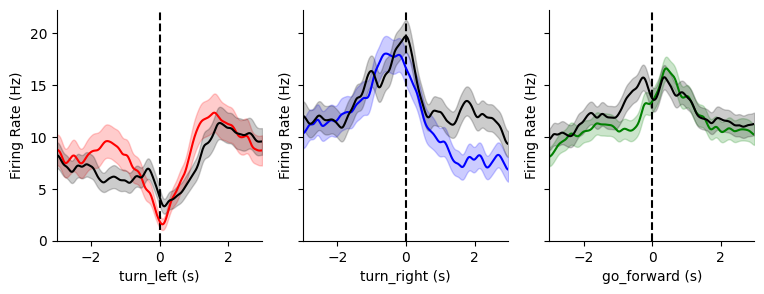

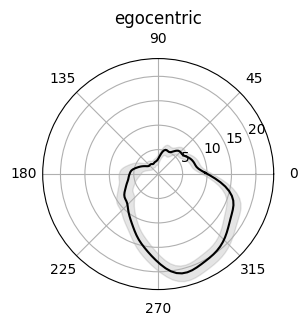

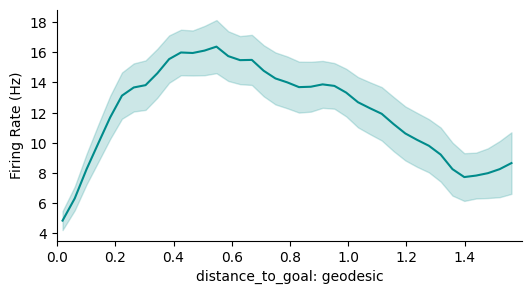

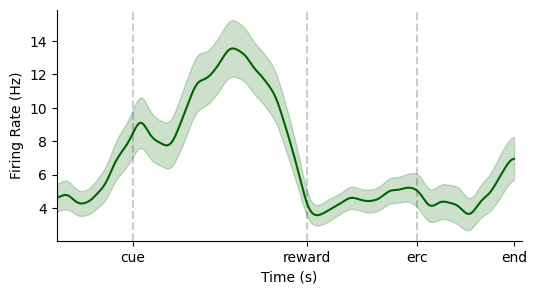

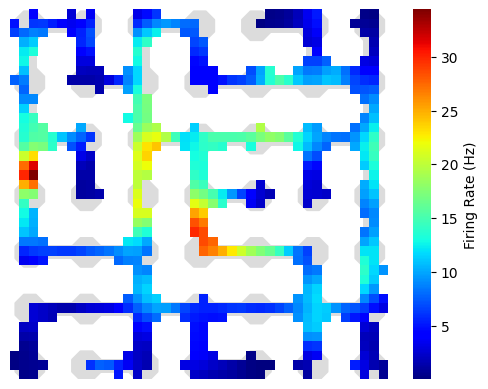

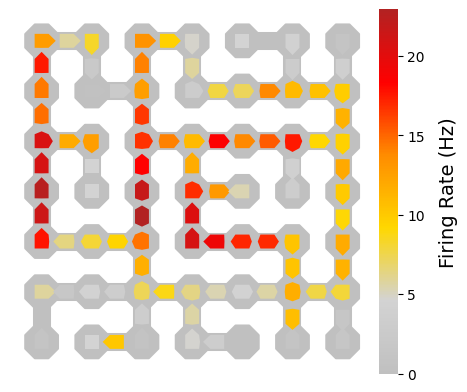

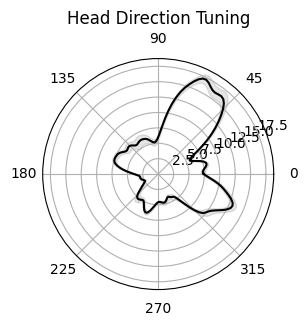

In [25]:
for feat in [
    "actions",
    "angle_to_goal",
    "distance_to_goal",
    "trial_events",
    "spatial",
    "place_direction",
    "head_direction",
]:
    Cluster.plot_tuning(feature=feat)

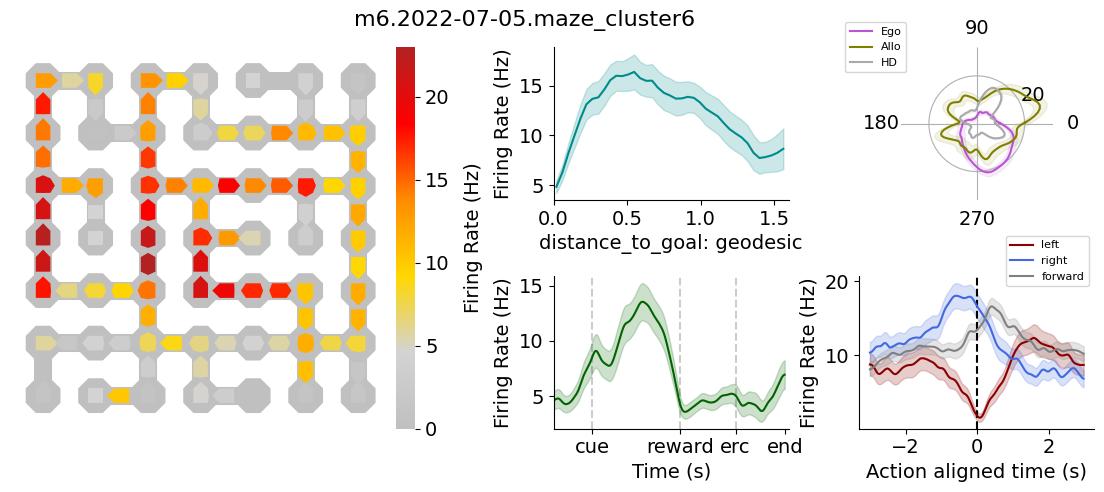

In [27]:
# we can also a summary of all a cluster's tuning features with
from GridMaze.analysis.cluster_tuning import summary

fig = summary.plot_tuning_summary_concise(Cluster)

Note:
- you can also load the data associated with each tuning feature with:

In [26]:
spikes, pos, simple_maze = Cluster.load_tuning_data(feature="spatial")